<a href="https://colab.research.google.com/github/GoradiaNishant/DSML/blob/main/Books_Recomendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 296kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617581 sha256=e9af9d6360459f8d118de789e52397a672f7d84a02465af1495549c65910c8fe
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel

from surprise import SVD,Reader,Dataset
from surprise.model_selection import cross_validate,KFold

import requests
from PIL import Image
from io import BytesIO
import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
books = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/books.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/ratings.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/tags.csv')
book_tags = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/book_tags.csv')

In [ ]:
for i in [books,ratings,tags,book_tags]:
  print(f"{i.shape[0]} Entries")

10000 Entries
981756 Entries
34252 Entries
999912 Entries


In [ ]:
for i in [books,ratings,tags,book_tags]:
  print(i.isnull().sum())
  print("==========")

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64
book_id    0
user_id    0
rating     0
dtype: int64
tag_id      0
tag_name    0
dtype: int64
goodreads_book_id    0
tag_id               0
count                0
dtype: int64


In [ ]:
nullcount=books.isnull().sum()

In [ ]:
nullcount[nullcount>0]

isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64

In [ ]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [ ]:
books["original_publication_year"].min(),books["original_publication_year"].max()#new

(-1750.0, 2017.0)

In [ ]:
for x in ["original_publication_year"]:
  books=books[books[x].notnull()]

for x in ["isbn"]:
  books=books[books[x].notnull()]

for x in ["isbn13"]:
  books=books[books[x].notnull()]

for x in ["original_title"]:
  books=books[books[x].notnull()]

for x in ["language_code"]:
  books=books[books[x].notnull()]

In [ ]:
books=books[books["original_publication_year"]>0]
books["original_publication_year"].min(),books.shape

(8.0, (7832, 23))

In [ ]:
books.isnull().sum()

book_id                      0
goodreads_book_id            0
best_book_id                 0
work_id                      0
books_count                  0
isbn                         0
isbn13                       0
authors                      0
original_publication_year    0
original_title               0
title                        0
language_code                0
average_rating               0
ratings_count                0
work_ratings_count           0
work_text_reviews_count      0
ratings_1                    0
ratings_2                    0
ratings_3                    0
ratings_4                    0
ratings_5                    0
image_url                    0
small_image_url              0
dtype: int64

In [ ]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [ ]:
#removing useless columns
drop_col=['best_book_id','ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5','work_id','small_image_url','isbn','isbn13']
books.drop(drop_col,axis=1,inplace=True)

In [ ]:
books.head()

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,image_url
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,https://images.gr-assets.com/books/1447303603m...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,https://images.gr-assets.com/books/1474154022m...
2,3,41865,226,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,https://images.gr-assets.com/books/1361039443m...
3,4,2657,487,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,https://images.gr-assets.com/books/1361975680m...
4,5,4671,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,https://images.gr-assets.com/books/1490528560m...


In [ ]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
list(ratings.rating.unique())

[5, 3, 4, 1, 2]

In [ ]:
rating_book=ratings.groupby('book_id').book_id.apply(lambda x:len(x)).sort_values().to_frame()

In [ ]:
rating_book.min(),rating_book.max()

(book_id    8
 dtype: int64, book_id    100
 dtype: int64)

In [ ]:
rating_user=ratings.groupby('user_id').book_id.apply(lambda x:len(x)).sort_values().to_frame()

In [ ]:
rating_user.min(),rating_user.max()

(book_id    2
 dtype: int64, book_id    200
 dtype: int64)

In [ ]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
data=pd.merge(book_tags,tags,left_on="tag_id",right_on="tag_id",how="inner")
data

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read
...,...,...,...,...
999907,31538635,14690,6,hogwarts
999908,32848471,16149,21,jan-2017
999909,33288638,27821,9,single-mom
999910,33288638,11478,7,fave-author


In [ ]:
books.columns

Index(['book_id', 'goodreads_book_id', 'books_count', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'image_url'],
      dtype='object')

In [ ]:
titles=books[['book_id','goodreads_book_id','authors']]
titles

,book_id,goodreads_book_id,authors
0,1,2767052,Suzanne Collins
1,2,3,"J.K. Rowling, Mary GrandPré"
2,3,41865,Stephenie Meyer
3,4,2657,Harper Lee
4,5,4671,F. Scott Fitzgerald
...,...,...,...
9994,9995,15613,Herman Melville
9995,9996,7130616,Ilona Andrews
9996,9997,208324,Robert A. Caro
9997,9998,77431,Patrick O'Brian


In [ ]:
goodreaddata=pd.merge(titles,data,left_on="goodreads_book_id",right_on="goodreads_book_id",how="inner")
goodreaddata

,book_id,goodreads_book_id,authors,tag_id,count,tag_name
0,1,2767052,Suzanne Collins,30574,11314,to-read
1,1,2767052,Suzanne Collins,11305,10836,fantasy
2,1,2767052,Suzanne Collins,11557,50755,favorites
3,1,2767052,Suzanne Collins,8717,35418,currently-reading
4,1,2767052,Suzanne Collins,33114,25968,young-adult
...,...,...,...,...,...,...
783195,9999,8565083,Peggy Orenstein,32735,17,womens-studies
783196,9999,8565083,Peggy Orenstein,11677,10,feminist-lit
783197,9999,8565083,Peggy Orenstein,32711,8,women-s-issues
783198,9999,8565083,Peggy Orenstein,11679,6,feminist-non-fiction


In [ ]:
books[['book_id','original_publication_year','average_rating', 'ratings_count']].describe()


,book_id,original_publication_year,average_rating,ratings_count
count,7832.000000,7832.000000,7832.000000,7.832000e+03
mean,4731.941522,1989.157176,3.995598,6.113743e+04
std,2889.319596,61.456877,0.251093,1.752793e+05
min,1.000000,8.000000,2.470000,2.773000e+03
25%,2188.750000,1989.000000,3.840000,1.427075e+04
50%,4612.500000,2004.000000,4.010000,2.282450e+04
75%,7193.250000,2010.000000,4.170000,4.622725e+04
max,9999.000000,2017.000000,4.820000,4.780653e+06


In [ ]:
sorted(books.original_publication_year.unique())

<Figure size 864x432 with 0 Axes>

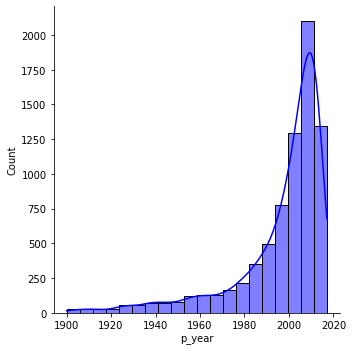

In [ ]:
plt.figure(figsize=(12,6))
year_filter=books[(books['original_publication_year']>=1900)]
sns.displot(year_filter["original_publication_year"],kde=True,bins=20,color='blue')
plt.xlabel("p_year")
plt.show()

In [ ]:
books.columns

Index(['book_id', 'goodreads_book_id', 'books_count', 'authors',
       'original_publication_year', 'original_title', 'title', 'language_code',
       'average_rating', 'ratings_count', 'work_ratings_count',
       'work_text_reviews_count', 'image_url'],
      dtype='object')

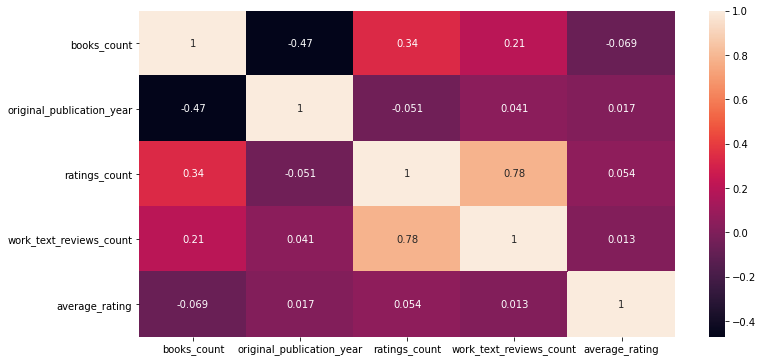

In [ ]:
plt.figure(figsize=(12,6))
corr=books[["books_count","original_publication_year","ratings_count","work_text_reviews_count","average_rating"]].corr()
sns.heatmap(corr,annot=True)
plt.show()

In [ ]:
books[["title","ratings_count"]].sort_values(by=["ratings_count"],ascending=False).head(10)

,title,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",4780653
1,Harry Potter and the Sorcerer's Stone (Harry P...,4602479
2,"Twilight (Twilight, #1)",3866839
3,To Kill a Mockingbird,3198671
4,The Great Gatsby,2683664
5,The Fault in Our Stars,2346404
6,The Hobbit,2071616
7,The Catcher in the Rye,2044241
9,Pride and Prejudice,2035490
8,"Angels & Demons (Robert Langdon, #1)",2001311


In [ ]:
books[["title","average_rating"]].sort_values(by=["average_rating"],ascending=False).head(10)

,title,average_rating
3627,The Complete Calvin and Hobbes,4.82
861,"Words of Radiance (The Stormlight Archive, #2)",4.77
8853,Mark of the Lion Trilogy,4.76
4482,It's a Magical World: A Calvin and Hobbes Coll...,4.75
6360,There's Treasure Everywhere: A Calvin and Hobb...,4.74
421,"Harry Potter Boxset (Harry Potter, #1-7)",4.74
6919,The Indispensable Calvin and Hobbes,4.73
3752,"Harry Potter Collection (Harry Potter, #1-6)",4.73
6589,The Authoritative Calvin and Hobbes: A Calvin ...,4.73
9565,Attack of the Deranged Mutant Killer Monster S...,4.72


In [ ]:
data.head(2)

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read


In [ ]:
list_tags=data.groupby(by="goodreads_book_id")["tag_name"].apply(set).apply(list)


In [ ]:
books["tags"]=books["goodreads_book_id"].apply(lambda x: " ".join(list_tags[x]))

In [ ]:
books["tags"]

0       ya-lit favourite-books read-more-than-once fan...
1       favourite-books read-more-than-once fantasy re...
2       ya-lit abandoned read-more-than-once fantasy r...
3       reread classics childhood own-it american-clas...
4       read-more-than-once reread classics read-in-20...
                              ...                        
9994    classics read-in-2012 law american-classics hi...
9995    fantasy read-in-2012 own-it part-of-a-series s...
9996    pleasure classics to-read-nonfiction owned-boo...
9997    reread 2006 classics own-it jack-aubrey owned-...
9998    abandoned parenting to-read-nonfiction read-in...
Name: tags, Length: 7832, dtype: object

In [ ]:

# Function to get the index of the book given its title. 
def get_book_id(book_title):
    index = books.index[books['original_title'] == book_title].to_list()
    if index:
        return index[0]
    else:
        return None

# Function to get the title of a book given its id.
def get_book_title(book_id):
    title = books.iloc[book_id]['original_title']
    return title

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['tags'])

In [ ]:
pd.DataFrame(tfidf_matrix.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,13151,13152,13153,13154,13155,13156,13157,13158,13159,13160,13161,13162,13163,13164,13165,13166,13167,13168,13169,13170,13171,13172,13173,13174,13175,13176,13177,13178,13179,13180,13181,13182,13183,13184,13185,13186,13187,13188,13189,13190
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# sim=cosine_similarity(tfidf_matrix,tfidf_matrix)

In [ ]:

similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function that takes the book title and returns the most similar books.
def get_similar_books(title, n=10):
    
    # Get the book id
    book_id = get_book_id(title)
    
    if book_id is None:
        print("Book not found.")
    else:
        
        # Get the pariwsie similarity scores of all books with that book
        book_similarities = list(enumerate(similarities[book_id]))
        
        # Sort the books based on the similarity scores
        book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
        
        # Get the scores of the 10 most similar book
        most_similar_books = book_similarities[1:1+n]
        movie_indices = [i[0] for i in most_similar_books]
   
    # Top 10 book recommendation
        rec = books[['title', 'image_url']].iloc[movie_indices]
        print("For this book we will recommand you:\n")
        for i in rec['image_url']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.show()

In [ ]:
books["original_title"].values


array(['The Hunger Games', "Harry Potter and the Philosopher's Stone",
       'Twilight', ..., 'Means of Ascent ', 'The Mauritius Command',
       'Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture'],
      dtype=object)

For this book we will recommand you:



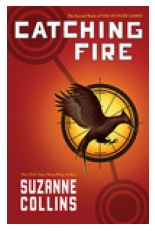

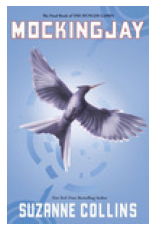

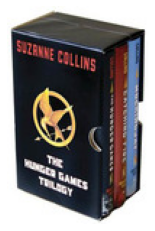

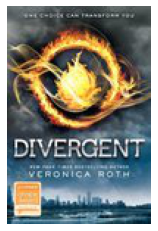

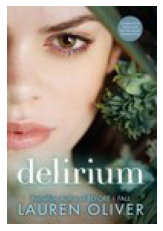

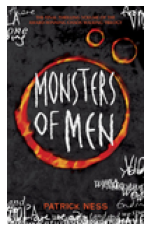

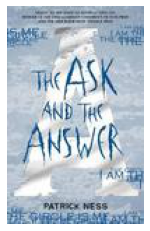

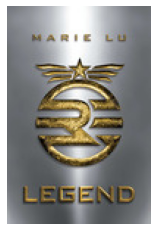

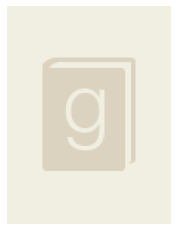

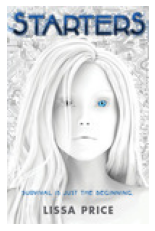

In [ ]:
get_similar_books('The Hunger Games')